Write a Python function adaboost_fit that implements the fit method for an AdaBoost classifier. The function should take in a 2D numpy array X of shape (n_samples, n_features)representing the dataset, a 1D numpy array y of shape (n_samples,)representing the labels, and an integer n_clf representing the number of classifiers. The function should initialize sample weights, find the best thresholds for each feature, calculate the error, update weights, and return a list of classifiers with their parameters.



In [26]:
import numpy as np
import math

def adaboost_fit(X,y,n_clf):
  n_samples,n_features=X.shape
  #initialize weights
  W=np.full(n_samples, (1/n_samples))#his creates a NumPy array of shape (n_samples,) (a 1D array) where each element is filled with the value 1/n_samples
  clfs=[]

  #iterate through each classifier
  for i in range(n_clf):
    clf={}
    min_error=float('inf')

    for feature_i in range(n_features): #what happens here is that for each classifier it runs through all the features and all the unique values of that feature to find the threshold for each featurer and also find the right polarity for that classifier
      feature_values=np.expand_dims(X[:,feature_i],axis=1)# because the dimension of X[:,feature_i] is (4,) and np.expand_dims make it (4,1) so instead of a 1d array it becomes 2D column array
      unique_values=np.unique(feature_values)#sorts the unique values of the features #explained below why we only need unique values for calculating the threshold
      #trying to find the threshold for each feature???
      for threshold in unique_values:
        p=1 # polarity
        prediction=np.ones(y.shape)
        prediction[X[:,feature_i]<threshold]=-1 #boolean indexing explained below, sets the one that the condition is true for them to -1 #polarity and why this is -1 is explained below
        #calculating error:sum of weighted misclassified samples #error is weighted sum sorta so like average or probability
        error= np.sum(W[y!=prediction]) #between zero and one because its is weighted and normalized
        #flip polarity # explanation below why this is needed
        if error>0.5: #0.5 because this is even worse than guessing
          p=-1
          error=1-error

        if error<min_error:# we base the polarity based on the min error between all the features and threshold # we want to find the feature with minimum error and also its threshold for each classifier
          min_error=error
          clf['polarity']=p
          clf['threshold']=threshold
          clf['feature_index']=feature_i

    #now that for each classifier seperately we have found their errors and best feature with its threshold and the polarity, we can calculate alpha (the weight for each classifier) based on the error
    #lowest error gets the highest alpha
    clf['alpha']=0.5*math.log((1.0-min_error)/(min_error+1e-10)) #this determines the importance and effect of each classifier on the whole ensemble classifier based on their min_error

    #update the predictions:updating the predictions for the weak classifier based on the best feature and threshold (stored in clf) and the corresponding polarity:
    #This part is re-evaluating and updating the predictions based on the classifier's parameters, which are derived from the current weak classifier:
    predictions=np.ones(y.shape)
    if clf['polarity']==1:
      #we now only split based on one feature and the chosen threshold (the best feature and its threshold to split based on min_error)
      predictions[X[:,clf['feature_index']]<clf['threshold']]=-1
    else:
      predictions[X[:,clf['feature_index']]>clf['threshold']]=-1
    #update weights (sample weights)
    #increase the weight of misclassified samples and decrease the weight of correctly classified samples
    W=W*np.exp(-clf['alpha']*y*predictions)
    #standarize the weights
    W/=np.sum(W)
    clfs.append(clf)

  return clfs



Potential Thresholds for Decision Stumps:

A decision stump (a weak classifier) is essentially a tree with just one decision node, which splits the data based on the value of a single feature.
To find the best decision threshold for a feature (say, feature 0), we need to consider potential values that could serve as thresholds for splitting the data into two groups: those less than the threshold and those greater than the threshold.
Unique Values Reduce Redundancy:

The feature values can be repeated across different samples, but we only need to consider unique values for thresholds. For example, if a feature takes values [2, 2, 3, 3, 5], we don't need to check each occurrence of 2 and 3 separately, because any value in the dataset that is equal to another value won't provide new information for setting a threshold.
By using only the unique values, we avoid unnecessary computations. For example, if the unique values are [2, 3, 5], we will only consider those as potential thresholds, rather than checking every instance of 2, 3, and 5.

prediction[X[:, feature_i] < threshold]:

Boolean indexing uses the boolean array (result of X[:, feature_i] < threshold) to select elements from the prediction array.
It applies the condition to the prediction array and selects the elements where the condition is True.

1. Understanding the Decision Stump:

A decision stump is a simple weak classifier that makes a prediction by comparing a feature value to a threshold. The classifier then assigns a predicted class label based on whether the feature value is greater than or less than the threshold.

2. Polarity and Thresholding:
The polarity determines the direction of the classification for each weak classifier:

Polarity = 1: If the feature value is greater than or equal to the threshold, the classifier predicts +1 (positive class). Otherwise, it predicts −1 (negative class).

Polarity = -1: This is when the classifier is flipped. In this case, the classifier would predict -1 for values greater than or equal to the threshold and +1 for values less than the threshold.

why flip the polarity?

For example, if the classifier predicts +1 for a threshold of 3, but it turns out that the correct label should be −1 for most of the samples, flipping the polarity ensures that predictions are reversed for better alignment with the true labels.

In [29]:
X = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
y = np.array([1, 1, -1, -1])
n_clf = 3

clfs = adaboost_fit(X, y, n_clf)
print(clfs)

[{'polarity': -1, 'threshold': 3, 'feature_index': 0, 'alpha': 11.512925464970229}, {'polarity': -1, 'threshold': 3, 'feature_index': 0, 'alpha': 11.512924909859024}, {'polarity': -1, 'threshold': 1, 'feature_index': 0, 'alpha': 11.512925464970229}]


The function fits an AdaBoost classifier on the dataset X with the given labels y and number of classifiers n_clf. It returns a list of classifiers with their parameters, including the polarity, threshold, feature index, and alpha values

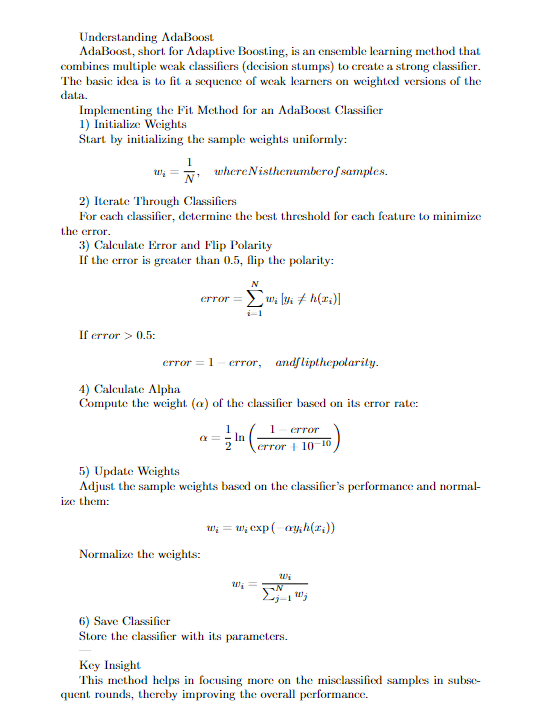

# Understanding AdaBoost

AdaBoost, short for Adaptive Boosting, is an ensemble learning method that combines multiple weak classifiers (decision stumps) to create a strong classifier. The basic idea is to fit a sequence of weak learners on weighted versions of the data.

## Implementing the Fit Method for an AdaBoost Classifier

### 1) Initialize Weights

Start by initializing the sample weights uniformly:

\[
w_i = \frac{1}{N}, \quad \text{where } N \text{ is the number of samples.}
\]

### 2) Iterate Through Classifiers

For each classifier, determine the best threshold for each feature to minimize the error.

### 3) Calculate Error and Flip Polarity

If the error is greater than 0.5, flip the polarity:

\[
\text{error} = \sum_{i=1}^{N} w_i \left[ y_i \neq h(x_i) \right]
\]

If \( \text{error} > 0.5 \):

\[
\text{error} = 1 - \text{error}, \quad \text{and flip the polarity.}
\]

### 4) Calculate Alpha

Compute the weight (\(\alpha\)) of the classifier based on its error rate:

\[
\alpha = \frac{1}{2} \ln \left( \frac{1 - \text{error}}{\text{error} + 10^{-10}} \right)
\]

### 5) Update Weights

Adjust the sample weights based on the classifier's performance and normalize them:

\[
w_i = w_i \exp \left( -\alpha y_i h(x_i) \right)
\]

Normalize the weights:

\[
w_i = \frac{w_i}{\sum_{j=1}^{N} w_j}
\]

### 6) Save Classifier

Store the classifier with its parameters.

---

## Key Insight

This method helps in focusing more on the misclassified samples in subsequent rounds, thereby improving the overall performance.
